In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def nDCG(relevances: np.ndarray, positions: np.ndarray) -> float:
    """Compute Normalized Discounted Cumulative Gain based on:
    - relevances: Numpy Array containing DCG Relevances (5 if booked, 1 if clicked)
    - positions: Numpy Array containing Positions (The display order) """
    
    positions_normalized = np.argsort(positions)
    relevances_ordered = relevances[positions_normalized]
    relevances_sorted = np.sort(relevances)[::-1]
    
    gain = 2 ** relevances_ordered - 1
    ideal_gain = 2 ** relevances_sorted - 1
    
    discount = np.log2(np.arange(len(positions)) + 2)
    
    DCG = np.sum(gain / discount)
    IDCG = np.sum(ideal_gain / discount)
    
    return DCG / IDCG


def nDCG_mean(dataframe: pd.DataFrame) -> float:
    """
    Calculate Mean Normalized Discounted Cumulative Gain on DataFrame
    DataFrame must have fields: [srch_id, relevance, position]
    """
    
    nDCG_sum = 0.0
    
    searches = dataframe.groupby('srch_id')
    
    for name, search in searches:
        nDCG_sum += nDCG(search.relevance.values, search.position.values)
    return nDCG_sum / len(searches)

In [3]:
# Load That Shit (does take a while)
train_df = pd.read_csv("data/training_set_VU_DM_2014.csv")
test_df = pd.read_csv("data/test_set_VU_DM_2014.csv")

In [4]:
# Reorganize DataFrame (a.k.a. throw out competitor info): handy for tweaking/overview?

def reorganize_train(df: pd.DataFrame):
    return df[[
        # ID
        'srch_id',
        
        # Labels (to predict)
        'position',
        'relevance',
        'click_bool',
        'booking_bool',

        # Per Seach Features
        'date_time',
        'site_id',
        'srch_destination_id',
        'srch_length_of_stay',
        'srch_booking_window',
        'srch_adults_count',
        'srch_children_count',
        'srch_room_count',
        'srch_saturday_night_bool',
        'srch_query_affinity_score',
        'orig_destination_distance',

        # Property Features
        'price_usd',
        'promotion_flag',
        'prop_country_id',
        'prop_id',
        'prop_starrating',
        'prop_review_score',
        'prop_brand_bool',
        'prop_location_score1',
        'prop_location_score2',
        'prop_log_historical_price',

        # Visitor Features
        'visitor_location_country_id',
        'visitor_hist_starrating',
        'visitor_hist_adr_usd',

        # Random Bool
        'random_bool'
    ]]


def reorganize_test(df: pd.DataFrame):
    return df[[
        # ID
        'srch_id',

        # Per Seach Features
        'date_time',
        'site_id',
        'srch_destination_id',
        'srch_length_of_stay',
        'srch_booking_window',
        'srch_adults_count',
        'srch_children_count',
        'srch_room_count',
        'srch_saturday_night_bool',
        'srch_query_affinity_score',
        'orig_destination_distance',

        # Property Features
        'price_usd',
        'promotion_flag',
        'prop_country_id',
        'prop_id',
        'prop_starrating',
        'prop_review_score',
        'prop_brand_bool',
        'prop_location_score1',
        'prop_location_score2',
        'prop_log_historical_price',

        # Visitor Features
        'visitor_location_country_id',
        'visitor_hist_starrating',
        'visitor_hist_adr_usd',

        # Random Bool
        'random_bool'
    ]]

# Data Cleaning

In [5]:
# Clean NaN's (The Pandas Way)
def clean(df: pd.DataFrame):
    df.srch_query_affinity_score = df.srch_query_affinity_score.fillna(df.srch_query_affinity_score.mean())
    df.orig_destination_distance = df.orig_destination_distance.fillna(df.orig_destination_distance.mean())

    df.prop_location_score2 = df.prop_location_score2.fillna(df.prop_location_score2.quantile(0.2))

    df.visitor_hist_adr_usd = df.visitor_hist_adr_usd.fillna(df.visitor_hist_adr_usd.mean())
    df.visitor_hist_starrating = df.visitor_hist_starrating.fillna(df.visitor_hist_starrating.mean())
    df.prop_review_score = df.prop_review_score.fillna(df.prop_review_score.min())

In [6]:
# Check Percentage of NaN's per Column
def check_NaN(df: pd.DataFrame):
    for column in df.columns:
        print("{:50s}{:4.1%} {}".format(column, np.mean(df[column].isnull()), "NaN" if df[column].isnull().any() else ""))

# Feature Engineering

In [7]:
# Extract Month/Day/Hour from Datetime
def parse_dates(df: pd.DataFrame):
    dates = pd.DatetimeIndex(df['date_time'])

    df['month'] = dates.month
    df['day'] = dates.day
    df['hour'] = dates.hour

In [8]:
def normalize(df: pd.DataFrame, feature: str, with_respect_to: str):
    ft = df[feature]
    ft_mean = df.groupby(with_respect_to)[feature].transform('mean')
    ft_std = df.groupby(with_respect_to)[feature].transform('std')
    
    ft_std[ft_std == 0] = 1    
    return (ft - ft_mean) / ft_std

def normalize_features(df: pd.DataFrame):
    #Normalize Numerical Features with Respect to Search ID, Property ID and Destination ID and add those to the DataFrame
    for norm_group in ['srch_id', 'srch_destination_id', 'srch_booking_window', 'prop_id', 'prop_country_id', 'month',]:
        for feature in ['price_usd', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price']:
            df["{}_{}".format(feature, norm_group)] = normalize(df, feature, norm_group)
            
    # Clean Prop ID NaN's
    for feature in ['price_usd', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price']:
        df["{}_prop_id".format(feature)] = df["{}_prop_id".format(feature)].fillna(df["{}_prop_id".format(feature)].min())

In [9]:
def price_ranking(df: pd.DataFrame):
    # Add Price Ranking Feature (Lowest Price goes first, Highest price last, per query)
    df['price_ranking'] = df.groupby('srch_id')['price_usd'].transform(lambda x: np.argsort(x) / len(x))

In [10]:
def process(df: pd.DataFrame):
    clean(df)
    parse_dates(df)
    normalize_features(df)
    price_ranking(df)
    check_NaN(df)
    return df

relevance = np.zeros(len(train_df))
relevance[train_df['click_bool'] == 1] = 1
relevance[train_df['booking_bool'] == 1] = 5
train_df['relevance'] = relevance

print("Train")
train_df = process(reorganize_train(train_df))

print("\nTest")
test_df = process(reorganize_test(test_df))

Train


c:\users\bram\anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\bram\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\bram\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

srch_id                                           0.0% 
position                                          0.0% 
relevance                                         0.0% 
click_bool                                        0.0% 
booking_bool                                      0.0% 
date_time                                         0.0% 
site_id                                           0.0% 
srch_destination_id                               0.0% 
srch_length_of_stay                               0.0% 
srch_booking_window                               0.0% 
srch_adults_count                                 0.0% 
srch_children_count                               0.0% 
srch_room_count                                   0.0% 
srch_saturday_night_bool                          0.0% 
srch_query_affinity_score                         0.0% 
orig_destination_distance                         0.0% 
price_usd                                         0.0% 
promotion_flag                                  

In [11]:
# Compute Expedia nDCG Score on Train Set
# (This is the thing to beat!)
nDCG_mean(train_df[train_df['random_bool'] == 0])

0.5180382392402173

# Test/Train Split

In [22]:
# Sample Random Fraction of Searches of DataFrame (To Speed Up Shit)
# (This does take a while though...)
# RANDOM_FRACTION = 0.5
# selection = train_df.groupby('srch_id').filter(lambda x: np.random.uniform() < RANDOM_FRACTION)

In [26]:
selection = train_df

In [93]:
# Split Train and Test from random selection, again per Search ID
TEST_TRAIN_SPLIT = 0.8

unique_search_ids = np.unique(selection.srch_id)
mask = np.random.uniform(0, 1, len(unique_search_ids)) < TEST_TRAIN_SPLIT

train = selection[selection.srch_id.isin(unique_search_ids[mask])]
test = selection[selection.srch_id.isin(unique_search_ids[~mask])]

# Downsample Training Set Negative Instances (Tip From Owen)
DOWNSAMPLE = 0.15
train = pd.concat([train[train.relevance > 0], train[train.relevance == 0].sample(frac=DOWNSAMPLE)])

# Split Into Features and Labels
train_features = train.loc[:, 'site_id':]
train_labels = train['relevance']

test_features = test.loc[:, 'site_id':]
test_labels = test['relevance']

print(len(train), len(test))
print(np.mean(train_labels), np.mean(test_labels))

745715 992272
0.8317869427328135 0.15637143847654675


# Machine Learning

In [94]:
# Train Gradient Boosting Regressor on Train Features w.r.t. Train Labels (a.k.a. Relevances)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
classifier = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    max_features='sqrt',
    subsample=0.8,
    verbose=1
)
classifier.fit(train_features, train_labels)


# Predict Relevances
predict_labels = classifier.predict(test_features)

# Through Data to Calculate Score in new DataFrame
# Note that predicted position = - predicted relevance
result = pd.DataFrame({
    'srch_id': test.srch_id,
    'relevance': test.relevance,
    'position': -predict_labels})
print("Prediction:", nDCG_mean(result))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           3.0864           0.0236           12.27m
         2           3.0575           0.0307           12.21m
         3           3.0329           0.0233           12.15m
         4           2.9988           0.0229           11.89m
         5           2.9938           0.0183           11.78m
         6           2.9619           0.0225           11.70m
         7           2.9450           0.0174           11.89m
         8           2.9253           0.0202           12.01m
         9           2.9077           0.0169           12.30m
        10           2.8938           0.0133           12.42m
        20           2.7863           0.0073           12.14m
        30           2.7214           0.0052           11.16m
        40           2.6782           0.0029           10.36m
        50           2.6436           0.0021            9.66m
        60           2.6287           0.0014            8.98m
       

<Container object of 58 artists>

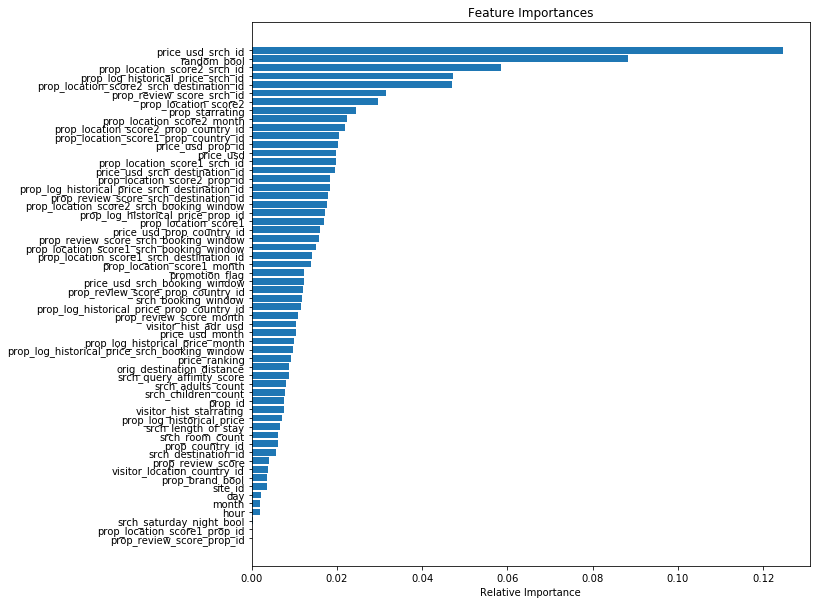

In [29]:
# Plot Feature Importances Graph
fig = plt.figure(figsize=(10, 10))
fi_sort = np.argsort(classifier.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Relative Importance")
plt.barh(np.arange(len(test_features.columns)), classifier.feature_importances_[fi_sort],
       tick_label=test_features.columns[fi_sort])

In [91]:
data = test.copy()

data_features = data.loc[:, 'site_id':]
data_predict = classifier.predict(data_features)

result = data[['srch_id', 'prop_id']]
# result = data[['srch_id', 'prop_id', 'relevance', 'click_bool', 'booking_bool', 'position']]
result['predict'] = -data_predict
result = result.sort_values(['srch_id', 'predict'])

# nDCG_mean(result)

c:\users\bram\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [92]:
print(np.unique(result['srch_id']))

result[result['srch_id'] == 64]

[    53     56     64 ... 332750 332755 332772]


,srch_id,prop_id,predict
776,64,102347,-2.169122
783,64,131865,-2.144826
759,64,45129,-1.852369
756,64,32917,-1.745597
757,64,32919,-1.557824
768,64,80377,-1.462841
772,64,93357,-1.405702
766,64,76754,-1.373959
774,64,99489,-1.361270
755,64,26203,-1.317071
